# Foodformer: Vision Transformer trained on the Food101 dataset

In [1]:
!pip install -Uqq datasets transformers[torch] torchmetrics pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from functools import partial

from torchvision.datasets import Food101
from transformers import ViTImageProcessor

model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor = partial(feature_extractor, return_tensors="pt")

train_ds = Food101(
    root="food101_dataset", split="train", transform=preprocessor, download=True
)
test_ds = Food101(
    root="food101_dataset",
    split="test",
    transform=preprocessor,
)

labels = train_ds.classes
print(f"Classes examples: {labels[:10]}")

100%|██████████| 4996278331/4996278331 [03:30<00:00, 23720930.54it/s]


Extracting food101_dataset/food-101.tar.gz to food101_dataset
Classes examples: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [3]:
import random

import torch
from torch.utils.data import DataLoader, Dataset


class ViTDataset(Dataset):
    """Package images pixel values and labels into a dictionary."""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self) -> int:
        """In PyTorch datasets have to override the length method."""
        return len(self.dataset)

    def __getitem__(self, index: int) -> dict:
        """This method defines how to feed the data during model training."""
        inputs_and_labels = dict()
        inputs_and_labels["pixel_values"] = self.dataset[index][0]["pixel_values"][0]
        inputs_and_labels["labels"] = self.dataset[index][1]
        return inputs_and_labels


train_dataset = ViTDataset(train_ds)
test_dataset = ViTDataset(test_ds)

# Optional: work with a subset of the data for development
train_dataset = torch.utils.data.Subset(
    train_dataset, random.sample(range(len(train_dataset)), 10000)
)
test_dataset = torch.utils.data.Subset(
    test_dataset, random.sample(range(len(train_dataset)), 1000)
)

# Create a dataloader object to chunk the datasets into batches
training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
testing_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [4]:
from getpass import getpass

wandb_logging = True

if wandb_logging:
    wandb_api_key = getpass("Copy your WANDB_API_KEY: ")

Copy your WANDB_API_KEY: ··········


In [5]:
import wandb
from pytorch_lightning.loggers import WandbLogger

if wandb_logging:
    wandb.login(key=wandb_api_key, relogin=True)

    logger = WandbLogger(
        project="Foodformer-new",
        name="VisionTransformer-base",
        checkpoint_name="vit",
        log_model=True,
        save_dir=".",
    )
else:
    logger = None

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ychiu14 (usf-annie). Use `wandb login --relogin` to force relogin


In [6]:
names = ["train", "test"]
datasets = [train_dataset, test_dataset]

# 🏺 create our Artifact
raw_data = wandb.Artifact(
    "food101-custom",
    type="dataset",
    description="Custom Food101 dataset, split into train/test",
    metadata={"sizes": [len(dataset) for dataset in datasets]},
)

for name, data in zip(names, datasets):
    with raw_data.new_file(name + ".pt", mode="wb") as fs:
        torch.save(data, fs)

# ✍️ Save the artifact to W&B.
wandb.run.log_artifact(raw_data)

<Artifact food101-custom>

Label: baby_back_ribs


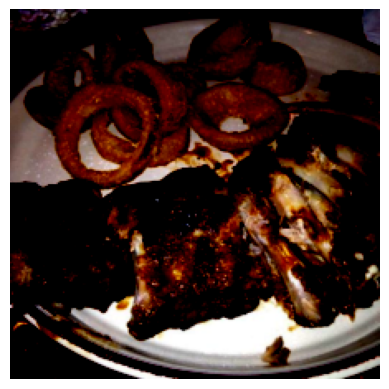

In [7]:
import matplotlib.pyplot as plt
import numpy as np

sample = test_dataset[7]
image = sample["pixel_values"].numpy()
if image.shape[0] == 3:
    # Convert image from "Channel first" to "Channel Last"
    image = np.moveaxis(image, 0, -1)

print(f"Label: {labels[sample['labels']]}")

plt.axis("off")
plt.imshow(image)

In [8]:
import pytorch_lightning as pl
from torch.nn.functional import cross_entropy, softmax
from torch.optim import AdamW
from torchmetrics.functional import accuracy
from transformers import ViTForImageClassification


class LightningVisionTransformer(pl.LightningModule):
    """Main model object: contains the model, defines how
    to run a forward pass, what the loss is, and the optimizer."""

    def __init__(self, model, learning_rate=2e-4, label_names=labels):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.label_names = label_names
        self.save_hyperparameters()

    def forward(self, batch):
        pixel_values = batch["pixel_values"]
        logits = self.model(pixel_values).logits
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.forward(batch)
        loss = cross_entropy(outputs, labels)
        self.log(
            "train_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.forward(batch)
        loss = cross_entropy(outputs, labels)
        self.log(
            "val_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )

        preds = outputs.argmax(dim=1)
        acc = accuracy(
            preds, labels, task="multiclass", num_classes=len(self.label_names)
        )
        self.log(
            "accuracy", acc, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )
        return loss

    def predict_step(self, pixel_values):
        logits = self.model(pixel_values).logits
        probas = softmax(logits, dim=1)
        values, indices = torch.topk(probas[0], 5)
        return_dict = {
            self.label_names[int(i)]: float(v) for i, v in zip(indices, values)
        }
        return return_dict


# Download pre-trained model from the HuggingFace model hub
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
)

# Create the Pytorch Lightning model
lightning_vit = LightningVisionTransformer(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [9]:
trainer = pl.Trainer(
    # max_steps=100, # For debug, comment for real training
    default_root_dir="/content",
    accelerator="gpu",
    max_epochs=1,
    logger=logger,
)

# Run evaluation before training
trainer.validate(lightning_vit, testing_loader)

# Train the model
trainer.fit(lightning_vit, training_loader, testing_loader)

trainer.save_checkpoint("best_model.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      accuracy_epoch       │   0.007000000216066837    │
│      val_loss_epoch       │    4.6435956954956055     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | ViTForImageClassification | 85.9 M
----------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
343.505   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Prediction: {'pork_chop': 0.10053078830242157, 'steak': 0.09474475681781769, 'prime_rib': 0.07828477770090103, 'filet_mignon': 0.07686794549226761, 'grilled_salmon': 0.04879981279373169}, real label: pork_chop


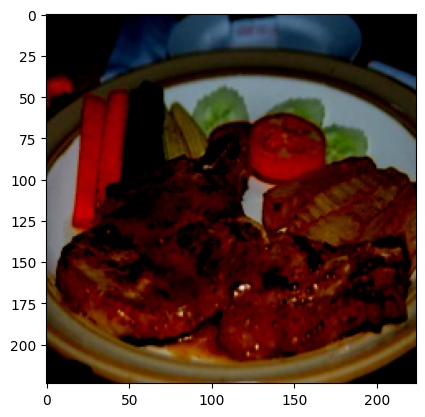

In [10]:
# Run a prediction for an example image
sample = test_dataset[45]
image = sample["pixel_values"].numpy()
torch_image = torch.tensor(image).unsqueeze(0)
pred = lightning_vit.predict_step(torch_image)

image = np.moveaxis(image, 0, -1)
label = labels[sample["labels"]]
plt.imshow(image)

print(f"Prediction: {pred}, real label: {label}")

In [11]:
wandb.finish()

accuracy_epoch,▁█
accuracy_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▇█▇██▇▇███▅▇
epoch,▁▁▁▁▁▁
train_loss_epoch,▁
train_loss_step,█▅▁
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▃▅█▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂██
val_loss_epoch,█▁
val_loss_step,████████████████▁▂▂▂▁▁▂▁▁▁▁▁▁▂▂▁
accuracy_epoch,0.627
accuracy_step,0.6
epoch,0


In [12]:
# (Optional) Upload your trained model to s3
# You can latter load it with:
# loaded_model = torch.load("./model.pt")
# loaded_model.eval()  # Run to finish loading the model
# !pip install -Uqq boto3
# import boto3

# model_file = "best_model.ckpt"

# s3 = boto3.client('s3', aws_access_key_id='XXXXXX', aws_secret_access_key='XXXXXX')
# with open(model_file, "rb") as f:
#     s3.upload_fileobj(f, "nico-ml-ops-course", "foodformer.ckpt")